In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import LSTM, Embedding
from keras.layers import BatchNormalization
from keras.layers import MaxPool1D
from keras.optimizers import Adam
from sklearn import preprocessing
import nltk
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from tensorflow.keras.preprocessing import sequence, text
from tqdm import tqdm
import opendatasets as od
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import contractions
# is, not, an: stopwords
from nltk.corpus import stopwords
import re  

In [215]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [216]:
df = pd.read_csv("/content/gdrive/MyDrive/NN/HW4/Q2_DATA/FA_KES_Dataset.csv",encoding='latin1')
df

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0
...,...,...,...,...,...,...,...
799,1965511221,Turkish Bombardment Kills 20 Civilians in Syria,28-08-2016 Turkish Bombardment Kills 20 Civili...,manar,8/28/2016,aleppo,1
800,1965511222,Martyrs as Terrorists Shell Aleppos Salah Eddin,17-08-2016 Martyrs as Terrorists Shell Aleppos...,manar,8/1/2016,aleppo,1
801,1965511224,Chemical Attack Kills Five Syrians in Aleppo SANA,03-08-2016 Chemical Attack Kills Five Syrians ...,manar,8/3/2016,aleppo,0
802,1965511226,5 Killed as Russian Military Chopper Shot down...,01-08-2016 5 Killed as Russian Military Choppe...,manar,8/1/2016,idlib,1


In [217]:
df2 = df.copy()

In [218]:
df2['text'] = df2['article_title'] + ' ' + df2['article_content']
del df2['unit_id']
del df2['article_title']
del df2['article_content']
del df2['source']
del df2['date']
del df2['location']
df2

,labels,text
0,0,Syria attack symptoms consistent with nerve ag...
1,0,Homs governor says U.S. attack caused deaths b...
2,0,Death toll from Aleppo bomb attack at least 11...
3,0,Aleppo bomb blast kills six Syrian state TV We...
4,0,29 Syria Rebels Dead in Fighting for Key Alepp...
...,...,...
799,1,Turkish Bombardment Kills 20 Civilians in Syri...
800,1,Martyrs as Terrorists Shell Aleppos Salah Eddi...
801,0,Chemical Attack Kills Five Syrians in Aleppo S...
802,1,5 Killed as Russian Military Chopper Shot down...


In [219]:
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

import contractions
def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    return ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words])
# str(text).split()

#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
lemmatizer = WordNetLemmatizer()
#defining a function for lemming
def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

#importing the Stemming function from nltk library
from nltk.stem.porter import PorterStemmer
#defining the object for stemming
stemmer = PorterStemmer()
#defining a function for stemming
def stemming_words(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

def clean_text(text):
    text = remove_url(text)
    text = remove_contractions(text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords(text)
    #text = stemming_words(text)
    #text = lemmatize_words(text)
    return text

In [220]:
df2['text'] = df2['text'].apply(clean_text)
df2

,labels,text
0,0,syria attack symptoms consistent nerve agent u...
1,0,homs governor says attack caused deaths see bi...
2,0,death toll aleppo bomb attack least sun apr de...
3,0,aleppo bomb blast kills six syrian state tv we...
4,0,syria rebels dead fighting key aleppo road sun...
...,...,...
799,1,turkish bombardment kills civilians syria turk...
800,1,martyrs terrorists aleppos salah eddin martyrs...
801,0,chemical attack kills five syrians aleppo sana...
802,1,killed russian military chopper shot syria kil...


In [221]:
X_train, X_test, y_train, y_test = train_test_split(df2['text'], df2['labels'], test_size=0.2, random_state=0)

In [222]:
print(X_train.shape)
print(X_test.shape)

(643,)
(161,)


In [223]:
token = text.Tokenizer(num_words=None)
max_len = 100

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train)
xtest_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [224]:
word_index

{'syrian': 1,
 'said': 2,
 'al': 3,
 'killed': 4,
 'aleppo': 5,
 'syria': 6,
 'people': 7,
 'regime': 8,
 'civilians': 9,
 'city': 10,
 'attack': 11,
 'forces': 12,
 'observatory': 13,
 'least': 14,
 'terrorist': 15,
 'government': 16,
 'province': 17,
 'terrorists': 18,
 'air': 19,
 'group': 20,
 'army': 21,
 'rebel': 22,
 'held': 23,
 'damascus': 24,
 'strikes': 25,
 'town': 26,
 'injured': 27,
 'russian': 28,
 'syrias': 29,
 'two': 30,
 'also': 31,
 'attacks': 32,
 'including': 33,
 'opposition': 34,
 'us': 35,
 'children': 36,
 'state': 37,
 'assad': 38,
 'coalition': 39,
 'since': 40,
 'daesh': 41,
 'idlib': 42,
 'fighters': 43,
 'near': 44,
 'rights': 45,
 'human': 46,
 'area': 47,
 'eastern': 48,
 'source': 49,
 'groups': 50,
 'rebels': 51,
 'rocket': 52,
 'war': 53,
 'areas': 54,
 'airstrikes': 55,
 'military': 56,
 'reported': 57,
 'three': 58,
 'chemical': 59,
 'one': 60,
 'militants': 61,
 'nusra': 62,
 'according': 63,
 'others': 64,
 'wounded': 65,
 'monitor': 66,
 'northe

In [225]:
X_test

8      explosion rocks town damascus sun feb explosio...
575    isis begins kill abducted christians hasaka sy...
616    militants killed car bomb blast syrias quneitr...
142    us backed syrian fighters pressing gunmen nort...
236    syria rebels kill aleppo assault capture villa...
                             ...                        
524    kurd led forces press islamic state near syria...
116    scores civilians killed airstrikes raqqa date ...
37     assad regime launches operation latakia region...
453    russian aerospace forces destroy isis oil refi...
48     fatalities expected increase suicide blast syr...
Name: text, Length: 161, dtype: object

In [226]:
xtest_pad

array([[   0,    0,    0, ...,   92,   64,    4],
       [ 763, 3140, 1076, ...,   90,   70,  338],
       [   2,  152,  746, ...,  329,   57, 1758],
       ...,
       [  21,  170, 5563, ...,  115,  458,  447],
       [ 110,  907,   89, ...,    6, 1543, 1620],
       [1332, 1937,  359, ...,   49,  532,  299]], dtype=int32)

In [227]:
#y_train = lb.fit_transform(y_train)
#y_test = lb.transform(y_test)
print(y_train)
print(y_test)

367    0
548    1
380    1
372    1
251    1
      ..
763    0
192    1
629    1
559    1
684    1
Name: labels, Length: 643, dtype: int64
8      1
575    0
616    1
142    1
236    1
      ..
524    1
116    0
37     1
453    1
48     1
Name: labels, Length: 161, dtype: int64


In [228]:
od.download("https://www.kaggle.com/datasets/takuok/glove840b300dtxt/code")

Skipping, found downloaded files in "./glove840b300dtxt" (use force=True to force download)


In [229]:
# load the GloVe vectors in a dictionary: (it takes some time...)

embeddings_index = {}
f = open('/content/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [03:52, 9460.09it/s] 

Found 2196017 word vectors.


In [230]:
word_index = token.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9493 unique tokens.


In [231]:
# can be set later: nr of words we care about max_features = 0
num_words =  len(word_index) + 1
print(num_words)

9494


In [232]:
embedding_dim = 300
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

100%|██████████| 9493/9493 [00:00<00:00, 140618.42it/s]


In [233]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add( Conv1D(128, 5, activation='relu', input_shape=(24, 20)))
model.add( MaxPool1D(pool_size = 2))

model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 300)          2848200   
                                                                 
 conv1d_8 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 48, 128)          0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM)               (None, 32)                20608     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,060,969
Trainable params: 212,769
Non-trainable params: 2,848,200
______________________________________

In [234]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [235]:
history = model.fit(xtrain_pad, y_train, 
                    epochs=10, 
                    batch_size=64, 
                    verbose=1, 
                    validation_data=(xtest_pad, y_test))

Epoch 1/10
11/11 [==============================] - 6s 262ms/step - loss: 0.6911 - accuracy: 0.5443 - val_loss: 0.7403 - val_accuracy: 0.4783
Epoch 2/10
11/11 [==============================] - 2s 205ms/step - loss: 0.6339 - accuracy: 0.6439 - val_loss: 0.7505 - val_accuracy: 0.4720
Epoch 3/10
11/11 [==============================] - 2s 206ms/step - loss: 0.5767 - accuracy: 0.7434 - val_loss: 0.8056 - val_accuracy: 0.4534
Epoch 4/10
11/11 [==============================] - 2s 202ms/step - loss: 0.5360 - accuracy: 0.7543 - val_loss: 0.8384 - val_accuracy: 0.4907
Epoch 5/10
11/11 [==============================] - 2s 203ms/step - loss: 0.4755 - accuracy: 0.8118 - val_loss: 0.8842 - val_accuracy: 0.4410
Epoch 6/10
11/11 [==============================] - 2s 203ms/step - loss: 0.4305 - accuracy: 0.8196 - val_loss: 0.9359 - val_accuracy: 0.4534
Epoch 7/10
11/11 [==============================] - 2s 205ms/step - loss: 0.3793 - accuracy: 0.8476 - val_loss: 0.9773 - val_accuracy: 0.4348
Epoch 

In [236]:
scores = model.predict(xtest_pad)
print("Auc: %.2f%%" % (roc_auc(np.round(scores),y_test)))

6/6 [==============================] - 0s 29ms/step
Auc: 0.48%


In [237]:
y_test.shape
y = np.array([y_test]).T
y.shape

(161, 1)

In [238]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y, np.round(scores))

In [239]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

    plt.show()

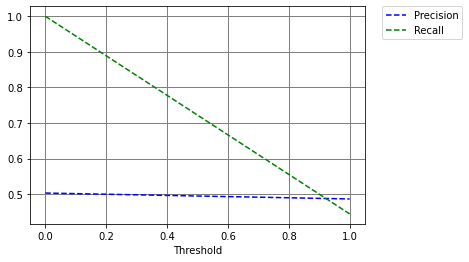

In [240]:
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)

[[42 38]
 [45 36]]


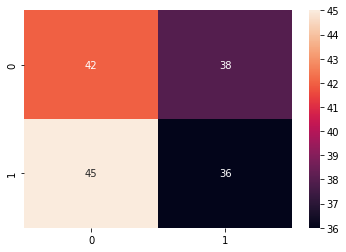

In [241]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y, np.round(scores))
print(cf_matrix)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

Test Loss: 1.0053404569625854
Test Accuracy: 0.48447203636169434
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


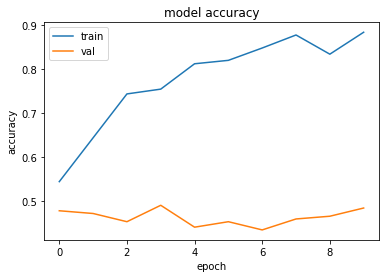

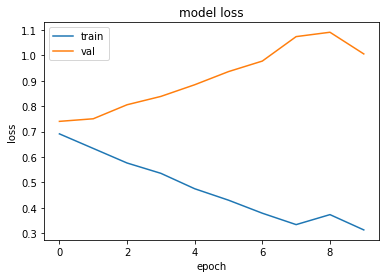

6/6 [==============================] - 0s 30ms/step
Accuracy : 0.496894
Precision : 0.246904
F1 score : 0.329888


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [242]:
score = model.evaluate(xtest_pad, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ypred = model.predict(xtest_pad) 
ypred = np.argmax(ypred,axis=1)
ypred = keras.utils.to_categorical(ypred, 2)
y_test = keras.utils.to_categorical(y, 2)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy : %f' % accuracy)

precision = precision_score(y_test, ypred,average='weighted')
print('Precision : %f' % precision)

f1 = f1_score(y_test, ypred,average='weighted')
print('F1 score : %f' % f1)